In [23]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

IDIM = 100
JDIM = 100
IJDIM = 100

#### **Initialization**

<p align="center"><img src="./image/1D_STAGGERED.jpg" style="width:60%; height:auto;"></p>

1. initialize domain sizes: XU & XP
2. initialize control volume sizes: DXP & DXU (relative to staggered grid)
3. initialize diemensions of faces (corresponds to Cartesian & Axisymmetric)

In [24]:
def init():
   global XP, XU, YP, YV
   global DXP, DXU, DYP, DYV
   global RP, RU
   global T, TSOR, BT
   global TKKP, ROCP
   global AW, AE, AN, AS, AP, APC
   global CORR, RES

   # DOMAIN ARRAYS
   XP  = np.zeros(IDIM)
   XU  = np.zeros(IDIM)
   
   ## CONTROL VOLUME SIZE ARRAYS
   DXP = np.zeros(IDIM) 
   DXU = np.zeros(IDIM)
   
   YP  = np.zeros(IDIM)
   YV  = np.zeros(IDIM)
   DYP = np.zeros(IDIM)
   DYV = np.zeros(IDIM)
   
   RP  = np.zeros(IDIM)
   RU  = np.zeros(IDIM)
   
   # TEMPERATURE ARRAYS
   T     = np.zeros((IDIM,JDIM))
   TSOR  = np.zeros((IDIM,JDIM))
   BT    = np.zeros((IDIM,JDIM)) # boundary T

   # PROPERTY COEFFICIENTS
   TKKP = np.zeros((IDIM,JDIM))
   ROCP = np.zeros((IDIM,JDIM))

   # TDMA COEFFICIENTS
   AW   = np.zeros((IDIM,JDIM))
   AE   = np.zeros((IDIM,JDIM))
   AN   = np.zeros((IDIM,JDIM))
   AS   = np.zeros((IDIM,JDIM))
   AP   = np.zeros((IDIM,JDIM))
   APC  = np.zeros((IDIM,JDIM))

   # CORRECTION & RESIDUALS
   CORR   = np.zeros((IDIM,JDIM))
   RES   = np.zeros((IDIM,JDIM))

   ## initialize domain sizes
   for i in range(1,NI+1):  XU[i]=DX0*(i-1)
   for i in range(1,NI):    XP[i]=(XU[i]+XU[i+1])/2
   for j in range(1,NJ+1):  YV[j]=DY0*(j-1)
   for j in range(1,NJ):    YP[j]=(YV[j]+YV[j+1])/2

   XP[0]=XU[1]
   XP[NI]=XU[NI]
   YP[0]=YV[1]
   YP[NJ]=YV[NJ]

   ## initialize control volume sizes
   for i in range(1,NI):    DXP[i]=XU[i+1]-XU[i]
   for i in range(1,NI+1):  DXU[i]=XP[i]-XP[i-1]
   for j in range(1,NJ):    DYP[j]=YV[j+1]-YV[j]
   for j in range(1,NJ+1):  DYV[j]=YP[j]-YP[j-1]

   ## initialize face dimensions
   if IR==0:
      for i in range(1,NI+1): RU[i]=1
      for i in range(0,NI+1): RP[i]=1
   else:
      for i in range(1,NI+1): RU[i]=np.fabs(XU[i])
      for i in range(0,NI+1): RP[i]=np.fabs(XP[i])

#### **Residual, Correction and TDMA**

For a single round, we don't expect that we can get an exact solution. \
(Actually it's never possible to get an "exact" solution if we iterate n --> inf).

Then approximating earned solution to the exact, the solution has to be updated in every round. \
Solver never knows at which degree at each round it has to update for apporoximation.

Here, the concept of "**RESIDUAL(`RES`)**" proposed:

$$
\begin{equation*}
\begin{align*}
A\mathbf{X}&=\mathbf{SOR} \\
\mathbf{E}&=\mathbf{X}-\mathbf{X_{old}} \\
\mathbf{R}&=\mathbf{SOR}-A\mathbf{X_{old}} \\
A\mathbf{E}&=\mathbf{RES} \qquad (\mathbf{RES}=\text{RESIDUAL})\\
\end{align*}
\end{equation*}
$$

At least, we can get how the earned is far from the exact. \
Then, we can set how much the solver has to update(=**correct**).

That is:

$$
\begin{equation*}
\begin{align*}
\mathbf{X_{old}}+\mathbf{CORR}&=\mathbf{X} \qquad (\mathbf{CORR}=\text{CORRECTION}) \\
A\mathbf{X_{old}}+A\mathbf{CORR}&=A\textbf{X}=\mathbf{SOR} \\ 
A\mathbf{CORR}
&=A\textbf{X}-A\mathbf{X_{old}}\\
&=\mathbf{SOR}-A\mathbf{X_{old}}\\
&=\mathbf{RES}

\end{align*}
\end{equation*}
$$

So we have a new goal for every round! Get **CORRECTION(`CORR`)** from the solver(TDMA)


In [25]:
def get_RES():
    RESMAX = 0
    FFMAX = 0
    FCMAX = 0
    for i in range(1, NI):
        for j in range(1, NJ):
            AT_neighbors = (
                AW[i][j] * T[i - 1][j]
                + AE[i][j] * T[i + 1][j]
                + AS[i][j] * T[i][j - 1]
                + AN[i][j] * T[i][j + 1]
            )
            AT_hat = AP[i][j] * T[i][j] - AT_neighbors

            RES[i][j] = TSOR[i][j] - AT_hat
            RESMAX = max(RESMAX, np.fabs(RES[i][j] / AP[i][j]))
            FFMAX = max(FFMAX, np.fabs(T[i][j]))
            FCMAX = max(FCMAX, np.fabs(CORR[i][j]))

    FFMAX = max(1.0e-30, FFMAX)
    RESMAX = RESMAX / FFMAX
    FCMAX = FCMAX / FFMAX

    return (RES, RESMAX, FFMAX, FCMAX)

#### **Line-by-Line TDMA (ADI: Alternating Direction Implicit)**

The conceptual problem we should solve will be:

\begin{equation*}
\begin{align*}
A\mathbf{CORR}
&=\mathbf{RES}\\
&=A_P\mathbf{C_{i,j}}+A_W\mathbf{C_{i-1,j}}+A_E\mathbf{C_{i-1,j}}+A_S\mathbf{C_{i,j-1}}+A_N\mathbf{C_{i,j+1}}\\
\end{align*}
\end{equation*}

But the thing is that, we have no way to solve *2 direction of vectors (x-direction, y-direction)* in a whole. \
Therefore, we can apply **implicit method** splitting caluation into 2 steps: 

1. x-directional calculation: regard y-directional vector as const --> add to RES
\begin{equation*}
\begin{align*}
A_P\mathbf{C_{i,j}}+A_W\mathbf{C_{i-1,j}}+A_E\mathbf{C_{i-1,j}}=\mathbf{RES}-(A_S\mathbf{C_{i,j-1}}+A_N\mathbf{C_{i,j+1}})
\end{align*}
\end{equation*}

2. y-directional calculation: regard x-directional vector as const --> add to RES
\begin{equation*}
\begin{align*}
A_P\mathbf{C_{i,j}}+A_S\mathbf{C_{i,j-1}}+A_N\mathbf{C_{i,j+1}}=\mathbf{RES}-(A_W\mathbf{C_{i-1,j}}+A_E\mathbf{C_{i-1,j}})
\end{align*}
\end{equation*}

Then our problem will be like this:

\begin{equation*}
\begin{align*}
\mathbf{RES}
&=\mathbf{TSOR}-A\mathbf{T}\\
&=\mathbf{TSOR}-(A_P\mathbf{T_{i,j}}-(A_W\mathbf{T_{i-1,j}}+A_E\mathbf{T_{i-1,j}}+A_S\mathbf{T_{i,j-1}}+A_N\mathbf{T_{i,j+1}}))\\
&=A_P\mathbf{C_{i,j}}+A_W\mathbf{C_{i-1,j}}+A_E\mathbf{C_{i-1,j}}+A_S\mathbf{C_{i,j-1}}+A_N\mathbf{C_{i,j+1}}\\[1em]
\end{align*}
\end{equation*}

\begin{equation*}
\begin{align*}
&\quad A_P\mathbf{C_{i,j}}-A_W\mathbf{C_{i-1,j}}-A_E\mathbf{C_{i+1,j}}\\
&=\mathbf{TSOR}-(A_P\mathbf{T_{i,j}}-(A_W\mathbf{T_{i-1,j}}+A_E\mathbf{T_{i-1,j}}+A_S\mathbf{T_{i,j-1}}+A_N\mathbf{T_{i,j+1}}))+(A_S\mathbf{C_{i,j-1}}+A_N\mathbf{C_{i,j+1}}) \qquad \text{(x-direction)}\\[0.3em]
\end{align*}
\end{equation*}

\begin{equation*}
\begin{align*}
&\quad A_P\mathbf{C_{i,j}}-A_S\mathbf{C_{i,j-1}}-A_N\mathbf{C_{i,j+1}}\\
&=\mathbf{TSOR}-(A_P\mathbf{T_{i,j}}-(A_W\mathbf{T_{i-1,j}}+A_E\mathbf{T_{i+1,j}}+A_S\mathbf{T_{i,j-1}}+A_N\mathbf{T_{i,j+1}}))+(A_W\mathbf{C_{i-1,j}}+A_E\mathbf{C_{i+1,j}}) \qquad \text{(y-direction)}
\end{align*}
\end{equation*}

In [26]:
np.set_printoptions(
    threshold=np.inf,  
    precision=3,       
    suppress=True,     
    linewidth=200      
)

def TDMA(start, end, AW, AE, AP, SOR):
    X = np.zeros(IJDIM)
    c_prime = np.zeros(IJDIM)
    d_prime = np.zeros(IJDIM)
    c_prime[start] = AE[start] / AP[start]
    d_prime[start] = SOR[start] / AP[start]
    
    for i in range(start + 1, end + 1):
        
        c_prime[i] = AE[i] / (AP[i] - AW[i] * c_prime[i - 1])
        d_prime[i] = (SOR[i] - AW[i] * d_prime[i - 1]) / (
            AP[i] - AW[i] * c_prime[i - 1]
        )
    X[end] = d_prime[end]
    for i in range(end - 1, start - 1, -1):
        X[i] = d_prime[i] - c_prime[i] * X[i + 1]

    return X


def LLTDMA(i_start, i_end, j_start, j_end, AW, AE, AS, AN, AP, SOR):
    SOR_x = np.zeros(IDIM)
    SOR_y = np.zeros(JDIM)
    X = np.zeros((IDIM, JDIM))

    for iter in range(2):
        # TDMA: x-direction
        for j in range(j_start, j_end+1):
            for i in range(i_start, i_end + 1):
                neighbors = AS[i][j] * X[i][j - 1] + AN[i][j] * X[i][j + 1]
                SOR_x[i] = SOR[i][j] + neighbors
            X[:, j]=TDMA(i_start, i_end, -AW[:, j], -AE[:, j], AP[:, j], SOR_x)
        
    
        # TDMA: y-direction
        for i in range(i_start, i_end+1):
            for j in range(j_start, j_end + 1):
                neighbors = AW[i][j] * X[i - 1][j] + AE[i][j] * X[i + 1][j]
                SOR_y[j] = SOR[i][j] + neighbors
            X[i, :] = TDMA(j_start, j_end, -AS[i, :], -AN[i, :], AP[i, :], SOR_y)

    return X

#### **2D Thermal Conduction Discretization Formula**

Governing equation for 2D Conduction,

\begin{equation*}
\begin{align*}
\rho c_p \frac{\partial T}{\partial t}
&= \frac{1}{r} \frac{\partial}{\partial x} \left( k r \frac{\partial T}{\partial x} \right)
+ \frac{\partial}{\partial y} \left( k \frac{\partial T}{\partial y} \right)
+ \dot{q} \\[1em]
\int_{y_{j-\frac{1}{2}}}^{y_{j+\frac{1}{2}}} \int_{x_{i-\frac{1}{2}}}^{x_{i+\frac{1}{2}}}
\rho c_p \frac{\partial T}{\partial t} \, r \, dx \, dy
&=
\int_{y_{j-\frac{1}{2}}}^{y_{j+\frac{1}{2}}} \int_{x_{i-\frac{1}{2}}}^{x_{i+\frac{1}{2}}}
\left[
\frac{1}{r} \frac{\partial}{\partial x} \left( k r \frac{\partial T}{\partial x} \right)
+ \frac{\partial}{\partial y} \left( k \frac{\partial T}{\partial y} \right)
+ \dot{q}
\right] r \, dx \, dy
\end{align*}
\end{equation*}


Regarding steady state and discretized form,

\begin{equation*}
\begin{align*}
0&=\left( \rho c_p r \, \Delta x \Delta y \right)_{i,j}
\frac{T_{i,j}^{n+1} - T_{i,j}^{n}}{\Delta t}
 \\

&=\left[
(k r \Delta y)_{i+\frac{1}{2},j}
\frac{T_{i+1,j} - T_{i,j}}{(\Delta x)_{i+\frac{1}{2}}}
-
(k r \Delta y)_{i-\frac{1}{2},j}
\frac{T_{i,j} - T_{i-1,j}}{(\Delta x)_{i-\frac{1}{2}}}
\right] \\
&+
\left[
(k r \Delta x)_{i,j+\frac{1}{2}}
\frac{T_{i,j+1} - T_{i,j}}{(\Delta y)_{j+\frac{1}{2}}}
-
(k r \Delta x)_{i,j-\frac{1}{2}}
\frac{T_{i,j} - T_{i,j-1}}{(\Delta y)_{j-\frac{1}{2}}}
\right] \\
&+
(q r \Delta x \Delta y)_{i,j}
\end{align*}
\end{equation*}

coefficients shorted as,

$$
AW[i][j]=\frac{(kr\Delta y)_{i-\frac{1}{2},j}}{\Delta x_{i-\frac{1}{2},j}} 
\qquad AE[i][j]=\frac{(kr\Delta y)_{i+\frac{1}{2},j}}{\Delta x_{i+\frac{1}{2},j}} \\
AS[i][j]=\frac{(kr\Delta x)_{i,j-\frac{1}{2}}}{\Delta y_{i,j-\frac{1}{2}}} 
\qquad AN[i][j]=\frac{(kr\Delta x)_{i,j+\frac{1}{2}}}{\Delta y_{i,j+\frac{1}{2}}} \\[1em]
\qquad AP[i][j]=AE[i][j]+AW[i][j]+AS[i][j]+AN[i][j] \\[1em]
\qquad \mathbf{TSOR[i][j]}=\dot q r (\Delta x_i) (\Delta y_j) \\[3em]
$$

\begin{equation*}
\begin{align*}
\mathbf{TSOR[i][j]} 
&=AP[i][j]*\mathbf{T[i][j]} \\
&-AW[i][j]*\mathbf{T[i-1][j]}-AE[i][j]*\mathbf{T[i+1][j]} \\
&-AS[i][j]*\mathbf{T[i][j-1]}-AN[i][j]*\mathbf{T[i][j+1]} \\
\end{align*}
\end{equation*}

control volume for discretization controlled as described,

<p align="center"><img src="./image/2D_CONTROL_VOLUME.jpg" style="width:70%; height:auto;"></p>

In [27]:
def set_BC(TW, TE, TS, TN):
    global T
    for j in range(0, NJ): T[0][j] = TW  # West Wall
    for j in range(0, NJ): T[NI][j] = TE  # East Wall
    for i in range(0, NI): T[i][0] = TS  # South Wall
    for i in range(0, NI): T[i][NJ] = TN  # North Wall

def set_NEUMANN(option, flag):
    if option is None:
        return
    
    if flag == "pre":
        for j in range(1, NJ):
            if option.get("W") == "neumann": 
                AP[1][j] -= AW[1][j]
                AW[1][j] = 0
            if option.get("E") == "neumann": 
                AP[NIM][j] -= AE[NIM][j]
                AE[NIM][j] = 0
        for i in range(1, NI):
            if option.get("S") == "neumann": 
                AP[i][1] -= AS[i][1]
                AS[i][1] = 0
            if option.get("N") == "neumann": 
                AP[i][NJM] -= AN[i][NJM]
                AN[i][NJM] = 0 
        return

    if flag == "post":
        for j in range(1, NJ):
            if option.get("W") == "neumann": T[0][j] = T[1][j]
            if option.get("E") == "neumann": T[NI][j] = T[NIM][j]
        for i in range(1, NI):
            if option.get("S") == "neumann": T[i][0] = T[i][1]
            if option.get("N") == "neumann": T[i][NJ] = T[i][NJM]
        return

def solve_T(option=None):
    global CORR
    global T
    
    # TDMA coeffs
    for i in range(1, NI):
        for j in range(1, NJ):
            AW[i][j] = K0 * RU[i] * DYP[j] / DXU[i]
            AE[i][j] = K0 * RU[i + 1] * DYP[j] / DXU[i + 1]
            AS[i][j] = K0 * RP[i] * DXP[i] / DYV[j]
            AN[i][j] = K0 * RP[i] * DXP[i] / DYV[j + 1]
            AP[i][j] = AW[i][j] + AE[i][j] + AS[i][j] + AN[i][j]

            TSOR[i][j] = QDOT * RP[i] * DXP[i] * DYP[j]
    
    # boundary conds
    set_NEUMANN(option, "pre")

    # earn T_hat (T_numerical)
    for iter in range(ITERMAX):
        (RES, RESMAX, FFMAX, FCMAX) = get_RES()

        if iter % JUMP == 0:
            print(
                " iter= {:4d} T= {:11.3e} ResMax= {:11.3e} Fcmax= {:11.3e}".format(
                    iter, T[10][10], RESMAX, FCMAX
                )
            )
        if iter and RESMAX < ERRMAX and FCMAX < ERRMAX:
            print(
                " iter= {:4d} T= {:11.3e} ResMax= {:11.3e} Fcmax= {:11.3e}".format(
                    iter, T[10][10], RESMAX, FCMAX
                )
            )
            break

        CORR = LLTDMA(1, NIM, 1, NJM, AW, AE, AS, AN, AP, SOR=RES)

        for i in range(1, NI):
            for j in range(1, NJ):
                T[i][j] += T_RELAX * CORR[i][j]

        set_NEUMANN(option, "post")

    return T

In [28]:
def plot_results(input_T):
    x_coords = XP[1:NI] 
    y_coords = YP[1:NJ] 

    T_data = input_T[1:NI, 1:NJ]
    X_plot, Y_plot = np.meshgrid(x_coords, y_coords)
    T_plot = T_data.T
    
    plt.figure(figsize=(8, 6))
    contour_fill = plt.contourf(X_plot, Y_plot, T_plot, levels=15, cmap='jet')
    contour_lines = plt.contour(X_plot, Y_plot, T_plot, levels=15, colors='black', linewidths=0.5)
    
    plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
    plt.title(f'Temperature Distribution ({NIM}x{NJM} Grid)')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.colorbar(contour_fill, label='Temperature') 
    plt.axis('equal') 
    
    plt.show()

In [29]:
NI = 21
NJ = 21
NIM = NI - 1
NJM = NJ - 1
DX0 = 0.05
DY0 = 0.05
IR = 0

K0 = 1.0
# ROCP0 = 1.e6
QDOT = 0.0
ERRMAX = 1.0e-5
T_RELAX = 1.0

ITERMAX = 1000
JUMP = 10

In [30]:
print("------------Case 1: TW=0, TE=0, TS=0, TN=1------------")
init()
set_BC(TW=0, TE=0, TS=0, TN=1)
case1=solve_T()
print("------------------------------------------------------")

print("------------Case 2: TW=0, TE=1, TS=0, TN=1------------")
init()
set_BC(TW=0, TE=1, TS=0, TN=1)
case2=solve_T()
print("------------------------------------------------------")

print("------------Case 3: TW=0, TE=1, TS=0, TN=0------------")
init()
set_BC(TW=0, TE=1, TS=0, TN=0)
case3=solve_T(option={"N":"neumann"})
print("------------------------------------------------------")

print("------------Case 4: TW=0, TE=0, TS=0, TN=1------------")
init()
set_BC(TW=0, TE=0, TS=0, TN=1)
case4=solve_T(option={"W":"neumann","E":"neumann"})
print("------------------------------------------------------")

------------Case 1: TW=0, TE=0, TS=0, TN=1------------
 iter=    0 T=   0.000e+00 ResMax=   4.000e+29 Fcmax=   0.000e+00
 iter=   10 T=   1.624e-01 ResMax=   9.039e-04 Fcmax=   1.562e-02
 iter=   20 T=   2.195e-01 ResMax=   1.274e-04 Fcmax=   2.191e-03
 iter=   30 T=   2.278e-01 ResMax=   1.835e-05 Fcmax=   3.161e-04
 iter=   40 T=   2.290e-01 ResMax=   2.644e-06 Fcmax=   4.555e-05
 iter=   48 T=   2.292e-01 ResMax=   5.613e-07 Fcmax=   9.671e-06
------------------------------------------------------
------------Case 2: TW=0, TE=1, TS=0, TN=1------------
 iter=    0 T=   0.000e+00 ResMax=   6.667e+29 Fcmax=   0.000e+00
 iter=   10 T=   3.263e-01 ResMax=   1.655e-03 Fcmax=   2.854e-02
 iter=   20 T=   4.392e-01 ResMax=   2.392e-04 Fcmax=   4.115e-03
 iter=   30 T=   4.556e-01 ResMax=   3.447e-05 Fcmax=   5.939e-04
 iter=   40 T=   4.580e-01 ResMax=   4.968e-06 Fcmax=   8.560e-05
 iter=   50 T=   4.584e-01 ResMax=   7.159e-07 Fcmax=   1.234e-05
 iter=   52 T=   4.584e-01 ResMax=   4.859e

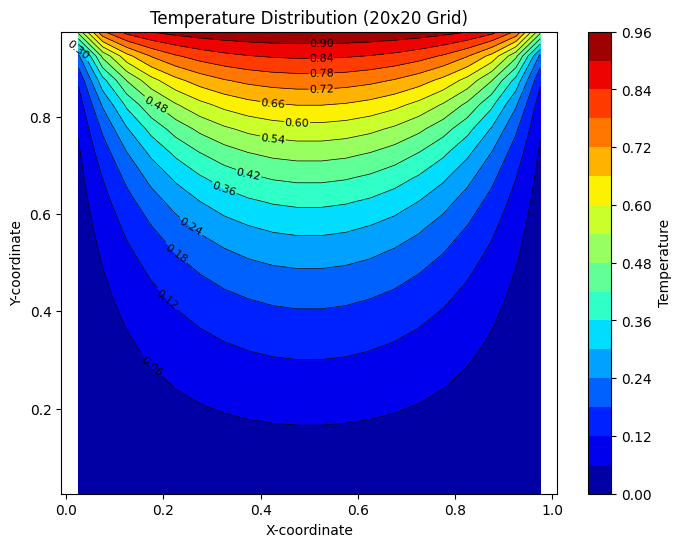

In [31]:
plot_results(case1)

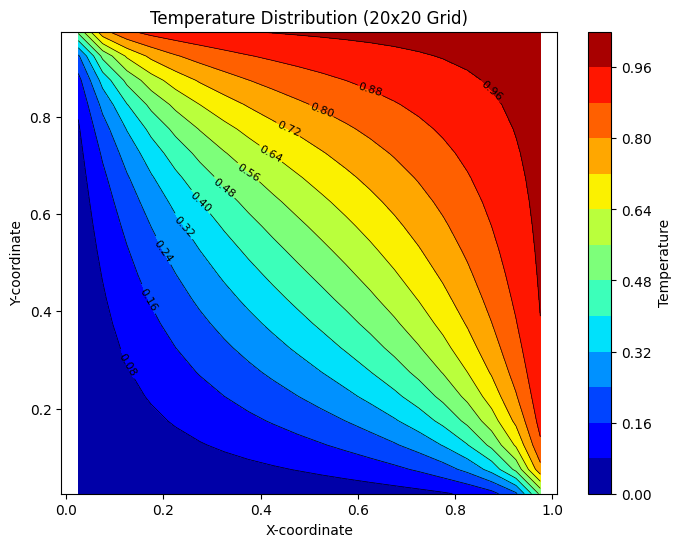

In [32]:
plot_results(case2)

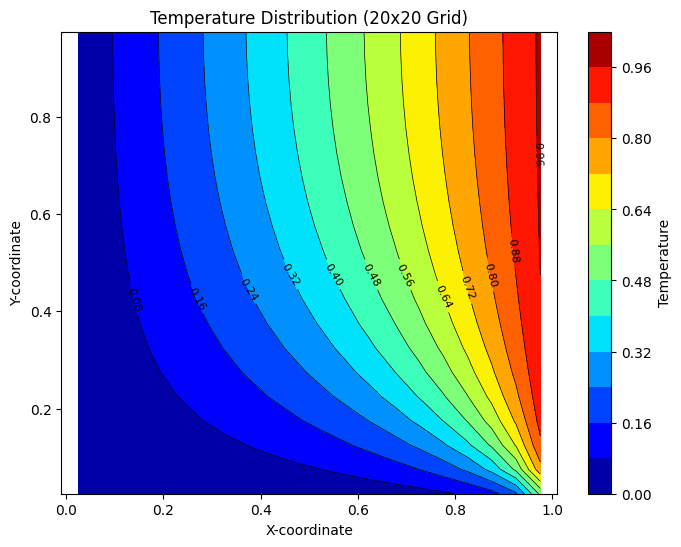

In [33]:
plot_results(case3)

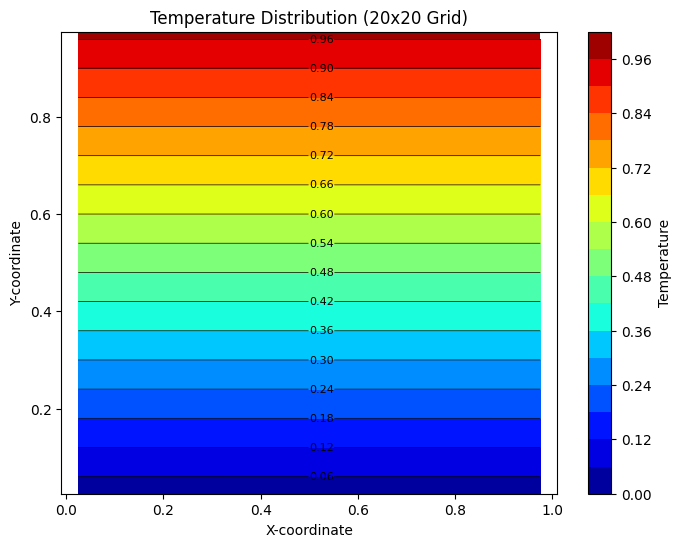

In [34]:
plot_results(case4)